# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [3]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [7]:
# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [8]:
env.reset()
rewards = []
for _ in range(100):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[ 0.16775454  0.94573102 -0.2243707  -1.66826545] 0 1.0 True {}
state, action, reward, done, info
[-0.12917727  0.11578133  0.22182181  0.4889185 ] 1 1.0 True {}
state, action, reward, done, info
[ 0.1165267   1.19448236 -0.24138782 -2.12769508] 1 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [9]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [11]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [12]:
def generator(states, hidden_size, action_size):
    with tf.variable_scope('generator'):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.01 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.01 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [13]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    outputs = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    one_hot_actions = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(outputs, one_hot_actions), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return outputs, Qs, loss

In [14]:
class QNetwork:
    def __init__(self, state_size, action_size, hidden_size):
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.outputs, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [15]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 400               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size

In [17]:
tf.reset_default_graph()
model = QNetwork(action_size=action_size, hidden_size=hidden_size, state_size=state_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [18]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                targetQ = sess.run(model.outputs, feed_dict)
                action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            next_targetQs = sess.run(model.outputs, feed_dict={model.states: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_targetQs[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_targetQs, axis=1))

            # Updating the model
            loss, _ = sess.run([model.loss, model.opt],
                                feed_dict={model.states: states,
                                           model.targetQs: targetQs,
                                           model.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 0 Total reward: 12.0 Training loss: 1.0997 Explore P: 0.9988
Episode: 1 Total reward: 20.0 Training loss: 1.4430 Explore P: 0.9968
Episode: 2 Total reward: 20.0 Training loss: 1.8132 Explore P: 0.9949
Episode: 3 Total reward: 15.0 Training loss: 3.5697 Explore P: 0.9934
Episode: 4 Total reward: 15.0 Training loss: 10.1871 Explore P: 0.9919
Episode: 5 Total reward: 11.0 Training loss: 8.6120 Explore P: 0.9908
Episode: 6 Total reward: 52.0 Training loss: 38.0032 Explore P: 0.9857
Episode: 7 Total reward: 24.0 Training loss: 75.0331 Explore P: 0.9834
Episode: 8 Total reward: 15.0 Training loss: 24.6119 Explore P: 0.9820
Episode: 9 Total reward: 12.0 Training loss: 31.3557 Explore P: 0.9808
Episode: 10 Total reward: 47.0 Training loss: 275.4164 Explore P: 0.9762
Episode: 11 Total reward: 23.0 Training loss: 468.4571 Explore P: 0.9740
Episode: 12 Total reward: 18.0 Training loss: 1144.8004 Explore P: 0.9723
Episode: 13 Total reward: 18.0 Training loss: 792.2774 Explore P: 0.9705
Ep

Episode: 114 Total reward: 20.0 Training loss: 17.2142 Explore P: 0.7144
Episode: 115 Total reward: 36.0 Training loss: 10.2028 Explore P: 0.7118
Episode: 116 Total reward: 21.0 Training loss: 100.2355 Explore P: 0.7104
Episode: 117 Total reward: 125.0 Training loss: 130.5006 Explore P: 0.7017
Episode: 118 Total reward: 17.0 Training loss: 25.3048 Explore P: 0.7005
Episode: 119 Total reward: 17.0 Training loss: 667.2529 Explore P: 0.6993
Episode: 120 Total reward: 107.0 Training loss: 31.4999 Explore P: 0.6920
Episode: 121 Total reward: 19.0 Training loss: 29.8154 Explore P: 0.6907
Episode: 122 Total reward: 23.0 Training loss: 18.3586 Explore P: 0.6891
Episode: 123 Total reward: 112.0 Training loss: 859.7716 Explore P: 0.6816
Episode: 124 Total reward: 26.0 Training loss: 33.8690 Explore P: 0.6798
Episode: 125 Total reward: 193.0 Training loss: 26.6884 Explore P: 0.6670
Episode: 126 Total reward: 28.0 Training loss: 73.7487 Explore P: 0.6652
Episode: 127 Total reward: 72.0 Training lo

Episode: 230 Total reward: 294.0 Training loss: 0.5649 Explore P: 0.1090
Episode: 231 Total reward: 252.0 Training loss: 2.0773 Explore P: 0.1066
Episode: 232 Total reward: 296.0 Training loss: 946.0477 Explore P: 0.1037
Episode: 233 Total reward: 10.0 Training loss: 791.8802 Explore P: 0.1036
Episode: 234 Total reward: 8.0 Training loss: 716.1682 Explore P: 0.1036
Episode: 235 Total reward: 12.0 Training loss: 1135.1478 Explore P: 0.1035
Episode: 236 Total reward: 10.0 Training loss: 2287.1743 Explore P: 0.1034
Episode: 237 Total reward: 8.0 Training loss: 3774.1348 Explore P: 0.1033
Episode: 238 Total reward: 9.0 Training loss: 2575.0747 Explore P: 0.1032
Episode: 239 Total reward: 8.0 Training loss: 2746.4546 Explore P: 0.1031
Episode: 240 Total reward: 11.0 Training loss: 2493.5652 Explore P: 0.1030
Episode: 241 Total reward: 9.0 Training loss: 3786.0898 Explore P: 0.1029
Episode: 242 Total reward: 9.0 Training loss: 4208.4443 Explore P: 0.1029
Episode: 243 Total reward: 10.0 Train

Episode: 341 Total reward: 211.0 Training loss: 3666.3687 Explore P: 0.0688
Episode: 342 Total reward: 258.0 Training loss: 1123.9736 Explore P: 0.0673
Episode: 343 Total reward: 242.0 Training loss: 168.7135 Explore P: 0.0660
Episode: 344 Total reward: 166.0 Training loss: 103.3244 Explore P: 0.0650
Episode: 345 Total reward: 246.0 Training loss: 55.5086 Explore P: 0.0637
Episode: 346 Total reward: 266.0 Training loss: 227.7944 Explore P: 0.0623
Episode: 348 Total reward: 43.0 Training loss: 24.0548 Explore P: 0.0600
Episode: 349 Total reward: 384.0 Training loss: 63.7220 Explore P: 0.0581
Episode: 350 Total reward: 274.0 Training loss: 24.1391 Explore P: 0.0568
Episode: 351 Total reward: 258.0 Training loss: 26.1327 Explore P: 0.0556
Episode: 353 Total reward: 63.0 Training loss: 53.3095 Explore P: 0.0536
Episode: 354 Total reward: 244.0 Training loss: 440.7536 Explore P: 0.0525
Episode: 355 Total reward: 244.0 Training loss: 22.3929 Explore P: 0.0515
Episode: 356 Total reward: 218.0

Episode: 455 Total reward: 110.0 Training loss: 2.2916 Explore P: 0.0176
Episode: 456 Total reward: 226.0 Training loss: 3.1088 Explore P: 0.0174
Episode: 457 Total reward: 217.0 Training loss: 2.5843 Explore P: 0.0172
Episode: 458 Total reward: 179.0 Training loss: 3.9732 Explore P: 0.0171
Episode: 459 Total reward: 177.0 Training loss: 2.8164 Explore P: 0.0170
Episode: 460 Total reward: 245.0 Training loss: 2.6673 Explore P: 0.0168
Episode: 461 Total reward: 171.0 Training loss: 1.5857 Explore P: 0.0167
Episode: 462 Total reward: 165.0 Training loss: 0.8633 Explore P: 0.0166
Episode: 463 Total reward: 196.0 Training loss: 0.7772 Explore P: 0.0165
Episode: 464 Total reward: 216.0 Training loss: 1.8182 Explore P: 0.0163
Episode: 465 Total reward: 204.0 Training loss: 2.4805 Explore P: 0.0162
Episode: 466 Total reward: 63.0 Training loss: 22.1840 Explore P: 0.0161
Episode: 467 Total reward: 8.0 Training loss: 35.6113 Explore P: 0.0161
Episode: 468 Total reward: 7.0 Training loss: 14.131

Episode: 568 Total reward: 161.0 Training loss: 6.8836 Explore P: 0.0113
Episode: 569 Total reward: 184.0 Training loss: 4.7663 Explore P: 0.0113
Episode: 570 Total reward: 195.0 Training loss: 6.1511 Explore P: 0.0113
Episode: 571 Total reward: 165.0 Training loss: 6.6487 Explore P: 0.0112
Episode: 572 Total reward: 159.0 Training loss: 10.1062 Explore P: 0.0112
Episode: 573 Total reward: 219.0 Training loss: 6.2930 Explore P: 0.0112
Episode: 574 Total reward: 228.0 Training loss: 7.6162 Explore P: 0.0112
Episode: 575 Total reward: 181.0 Training loss: 33.2779 Explore P: 0.0111
Episode: 576 Total reward: 164.0 Training loss: 5.8247 Explore P: 0.0111
Episode: 577 Total reward: 263.0 Training loss: 2.7785 Explore P: 0.0111
Episode: 578 Total reward: 188.0 Training loss: 12.4649 Explore P: 0.0111
Episode: 579 Total reward: 205.0 Training loss: 5.6536 Explore P: 0.0111
Episode: 580 Total reward: 314.0 Training loss: 9.3590 Explore P: 0.0110
Episode: 581 Total reward: 236.0 Training loss: 

Episode: 681 Total reward: 14.0 Training loss: 480.0002 Explore P: 0.0104
Episode: 682 Total reward: 11.0 Training loss: 552250.4375 Explore P: 0.0104
Episode: 683 Total reward: 9.0 Training loss: 239925.1719 Explore P: 0.0104
Episode: 684 Total reward: 8.0 Training loss: 768.2452 Explore P: 0.0104
Episode: 685 Total reward: 9.0 Training loss: 963.8537 Explore P: 0.0104
Episode: 686 Total reward: 8.0 Training loss: 850.7482 Explore P: 0.0104
Episode: 687 Total reward: 11.0 Training loss: 675.5954 Explore P: 0.0104
Episode: 688 Total reward: 9.0 Training loss: 748.7505 Explore P: 0.0104
Episode: 689 Total reward: 11.0 Training loss: 693.5931 Explore P: 0.0104
Episode: 690 Total reward: 12.0 Training loss: 663.7496 Explore P: 0.0104
Episode: 691 Total reward: 9.0 Training loss: 663.7713 Explore P: 0.0104
Episode: 692 Total reward: 8.0 Training loss: 450998.6562 Explore P: 0.0104
Episode: 693 Total reward: 10.0 Training loss: 937.2521 Explore P: 0.0104
Episode: 694 Total reward: 8.0 Train

Episode: 796 Total reward: 23.0 Training loss: 18.0803 Explore P: 0.0101
Episode: 798 Total reward: 99.0 Training loss: 23.5986 Explore P: 0.0101
Episode: 799 Total reward: 268.0 Training loss: 40.4458 Explore P: 0.0101
Episode: 800 Total reward: 181.0 Training loss: 22.1513 Explore P: 0.0101
Episode: 801 Total reward: 162.0 Training loss: 33.0103 Explore P: 0.0101
Episode: 802 Total reward: 149.0 Training loss: 26.1573 Explore P: 0.0101
Episode: 803 Total reward: 190.0 Training loss: 27.7096 Explore P: 0.0101
Episode: 804 Total reward: 160.0 Training loss: 20.9525 Explore P: 0.0101
Episode: 805 Total reward: 168.0 Training loss: 8.1634 Explore P: 0.0101
Episode: 806 Total reward: 215.0 Training loss: 27.9469 Explore P: 0.0101
Episode: 807 Total reward: 175.0 Training loss: 824.3836 Explore P: 0.0101
Episode: 808 Total reward: 179.0 Training loss: 33.3266 Explore P: 0.0101
Episode: 809 Total reward: 212.0 Training loss: 8.0414 Explore P: 0.0101
Episode: 810 Total reward: 261.0 Training

Episode: 945 Total reward: 11.0 Training loss: 168472.6562 Explore P: 0.0100
Episode: 946 Total reward: 9.0 Training loss: 176783.6719 Explore P: 0.0100
Episode: 947 Total reward: 8.0 Training loss: 143491.4531 Explore P: 0.0100
Episode: 948 Total reward: 12.0 Training loss: 152980.6562 Explore P: 0.0100
Episode: 949 Total reward: 10.0 Training loss: 367162.5000 Explore P: 0.0100
Episode: 950 Total reward: 11.0 Training loss: 256139.8281 Explore P: 0.0100
Episode: 951 Total reward: 9.0 Training loss: 458321.1875 Explore P: 0.0100
Episode: 952 Total reward: 8.0 Training loss: 580230.8750 Explore P: 0.0100
Episode: 953 Total reward: 11.0 Training loss: 97877504.0000 Explore P: 0.0100
Episode: 954 Total reward: 9.0 Training loss: 348785.3125 Explore P: 0.0100
Episode: 955 Total reward: 11.0 Training loss: 297482.0938 Explore P: 0.0100
Episode: 956 Total reward: 10.0 Training loss: 240809.7188 Explore P: 0.0100
Episode: 957 Total reward: 11.0 Training loss: 88988.9297 Explore P: 0.0100
Epi

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

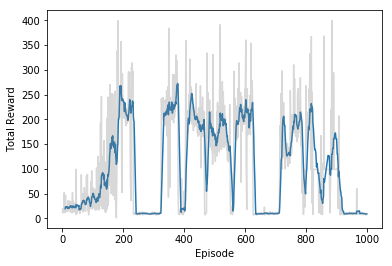

In [22]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(test_episodes):
        t = 0
        while t < test_max_steps:
            # env.render() 
            
            # Get action from Q-network
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            targetQ = sess.run(model.outputs, feed_dict)
            action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.